# Vergleich von Luftschadstoffdaten aus verschiedenen Quellen

## Datenaufbereitung

In [1]:
### Package Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, DateFormatter, WeekdayLocator

In [2]:
### file import, time formating, indexing
### s. https://luftdaten.berlin.de/station/mc115?period=1h&timespan=custom&start%5Bdate%5D=31.05.2024&start%5Bhour%5D=14&end%5Bdate%5D=19.06.2024&end%5Bhour%5D=13
### Zeitraum 31.05.2024 14:00 bis 19.06.2024 13:00

BLUME_data = 'ber_mc115_20240531-20240619.csv'
df_BLUME = pd.read_csv(BLUME_data, encoding =  "ISO-8859-1", sep=';', skiprows = 1)
df_BLUME = df_BLUME.drop(index = [0,1])
df_BLUME.rename(columns ={'Messkomponente':'Messzeit','Stickstoffdioxid':'NO2 [µg/m³]','Stickstoffmonoxid':'NO [µg/m³]','Stickoxide':'NOx [µg/m³]'},inplace = True)
df_BLUME = df_BLUME[['Messzeit','NO [µg/m³]','NO2 [µg/m³]','NOx [µg/m³]']]
df_BLUME = df_BLUME.set_index('Messzeit')
df_BLUME = df_BLUME.iloc[:,0:2]
df_BLUME.index = pd.to_datetime(df_BLUME.index, format = '%d.%m.%Y %H:%M')
df_BLUME = df_BLUME.astype({'NO [µg/m³]': 'float64'})
df_BLUME = df_BLUME.astype({'NO2 [µg/m³]': 'float64'})

In [3]:
### Die Daten von BLUME sind in µg/m³ angegeben. Zur besseren Vergleichbarkeit rechnen wir sie in  ppb um. Die Formel dafür lautet: 
### ppb = Konzentration * V_m / Molmasse
### Dabei haben wir die Konzentrationen gegeben. Die Molmasse ist durch den Stoff gegeben: 30,01 für NO, 46,01 für NO2
### Das molare Volumen ist V_m = RT/p, wobei R = 8,314 J/(K*mol) die Ideale Gaskonstante ist. Temperatur T und Luftdruck p müssen wir also von einer anderen Quelle mit berücksichtigen.
### Für T und p siehe https://open-meteo.com/en/docs/historical-weather-api#start_date=2024-05-31&end_date=2024-06-19&hourly=temperature_2m,surface_pressure

meteo_data = 'open-meteo-52.48N13.38E39m.csv'
df_meteo = pd.read_csv(meteo_data, sep=',',skiprows = [0,1])
df_meteo = df_meteo.rename(columns = {'time':'Messzeit','temperature_2m (°C)':'Temperatur (°C)','surface_pressure (hPa)':'Luftdruck (hPa)'})
df_meteo = df_meteo.set_index('Messzeit')
df_meteo.index = pd.to_datetime(df_meteo.index, format = '%Y-%m-%dT%H:%M')

#Wir erstellen aus den Celsius- die entsprechenden Kelvin- Werte. Diese könnte man zwar leicher mit df_meteo['Temperatur (°C)'] = df_meteo['Temperatur (°C)'] + 273,15 machen, aber das hier ist zu Vorführzwecken.
def celcius_to_kelvin(x):
    return x + 273.15
df_meteo['Temperatur (°C)'] = df_meteo['Temperatur (°C)'].apply(celcius_to_kelvin) 
df_meteo.rename(columns = {'Temperatur (°C)':'Temperatur (K)'}, inplace = True)

#Ideale Gaskonstante 
R = 8.314

# Berechene das Molvolumen
def V_m(row):
    return R*row['Temperatur (K)']/row['Luftdruck (hPa)']
df_meteo['Molvolumen (l/mol)'] = df_meteo.apply(V_m,axis = 1)*10 # der Faktor 10 = 1000 * 1/100 kommt daher, dass wir von m³ auf l im Zähler, und von hPa auf Pa im Nenner umrechnen

In [4]:
### Parts per billion (ppb) erstellen. Formel: ppb = Konzentration (µg/m³) * Molvolumen (l/mol) / Molmasse (g/mol)

df_BLUME['NO [ppb]'] = df_BLUME['NO [µg/m³]']*df_meteo['Molvolumen (l/mol)']/30.01
df_BLUME['NO2 [ppb]'] = df_BLUME['NO2 [µg/m³]']*df_meteo['Molvolumen (l/mol)']/46.01

## Plots

<function matplotlib.pyplot.show(close=None, block=None)>

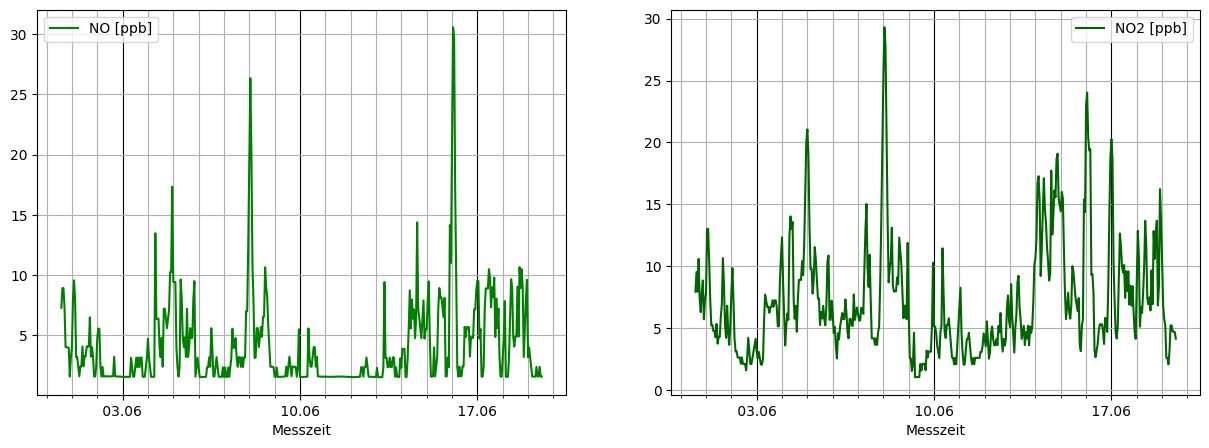

In [5]:
### Plots als Stundenmittel

fig_sidebyside_H, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(df_BLUME['NO [ppb]'], color = 'green', label='NO [ppb]')
ax[0].set_xlabel('Messzeit')
ax[0].legend()
ax[0].xaxis.set_major_locator(WeekdayLocator(byweekday=0))
ax[0].xaxis.set_minor_locator(WeekdayLocator(byweekday=[0,1,2,3,4,5,6]))
ax[0].xaxis.set_major_formatter(DateFormatter(" %d.%m "))
ax[0].xaxis.grid(True,which='major', color = 'black')
ax[0].xaxis.grid(True,which='minor')
ax[0].yaxis.grid(True)

ax[1].plot(df_BLUME['NO2 [ppb]'], color = 'darkgreen', label='NO2 [ppb]')
ax[1].set_xlabel('Messzeit')
ax[1].legend()
ax[1].xaxis.set_major_locator(WeekdayLocator(byweekday=0))
ax[1].xaxis.set_minor_locator(WeekdayLocator(byweekday=[0,1,2,3,4,5,6]))
ax[1].xaxis.set_major_formatter(DateFormatter(" %d.%m "))
ax[1].xaxis.grid(True,which='major', color = 'black')
ax[1].xaxis.grid(True,which='minor')
ax[1].yaxis.grid(True)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

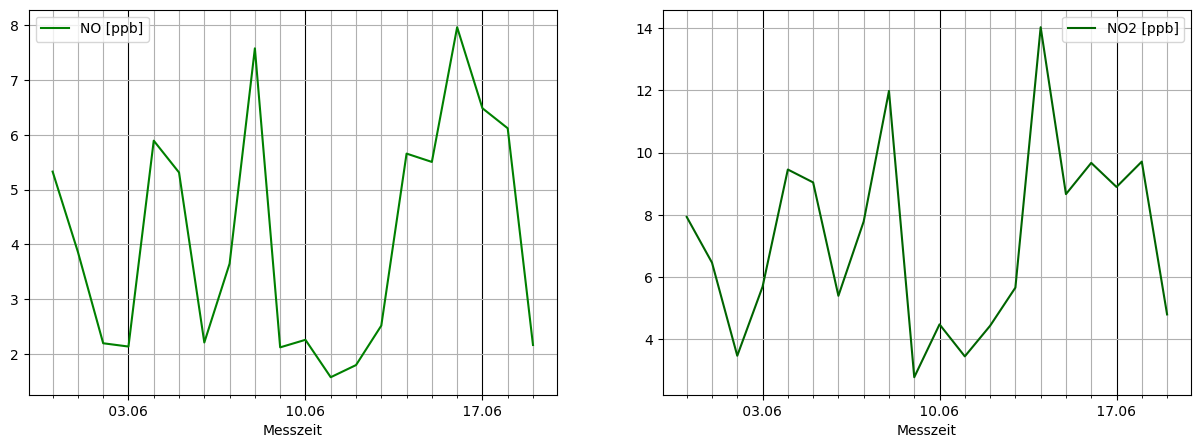

In [6]:
### Plots als Tagesmittel

fig_sidebyside_H, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(df_BLUME.resample('D').mean()['NO [ppb]'], color = 'green', label='NO [ppb]')
ax[0].set_xlabel('Messzeit')
ax[0].legend()
ax[0].xaxis.set_major_locator(WeekdayLocator(byweekday=0))
ax[0].xaxis.set_minor_locator(WeekdayLocator(byweekday=[0,1,2,3,4,5,6]))
ax[0].xaxis.set_major_formatter(DateFormatter(" %d.%m "))
ax[0].xaxis.grid(True,which='major', color = 'black')
ax[0].xaxis.grid(True,which='minor')
ax[0].yaxis.grid(True)

ax[1].plot(df_BLUME.resample('D').mean()['NO2 [ppb]'], color = 'darkgreen', label='NO2 [ppb]')
ax[1].set_xlabel('Messzeit')
ax[1].legend()
ax[1].xaxis.set_major_locator(WeekdayLocator(byweekday=0))
ax[1].xaxis.set_minor_locator(WeekdayLocator(byweekday=[0,1,2,3,4,5,6]))
ax[1].xaxis.set_major_formatter(DateFormatter(" %d.%m "))
ax[1].xaxis.grid(True,which='major', color = 'black')
ax[1].xaxis.grid(True,which='minor')
ax[1].yaxis.grid(True)

plt.show

In [7]:
#Erstelle ein Dataframe für die durchschnittliche Konzentration über Tageszeiten

df_BLUME['Tageszeit'] = df_BLUME.index.strftime('%H:%M') #temp- Spalte, die nachher wieder gelöscht wird.

df_daytime = pd.DataFrame()
col_no = df_BLUME.groupby('Tageszeit')['NO [ppb]'].mean()
col_no2 = df_BLUME.groupby('Tageszeit')['NO2 [ppb]'].mean()
df_daytime['NO [ppb]'],df_daytime['NO2 [ppb]'] = col_no, col_no2

df_BLUME.drop('Tageszeit', axis = 1, inplace = True)

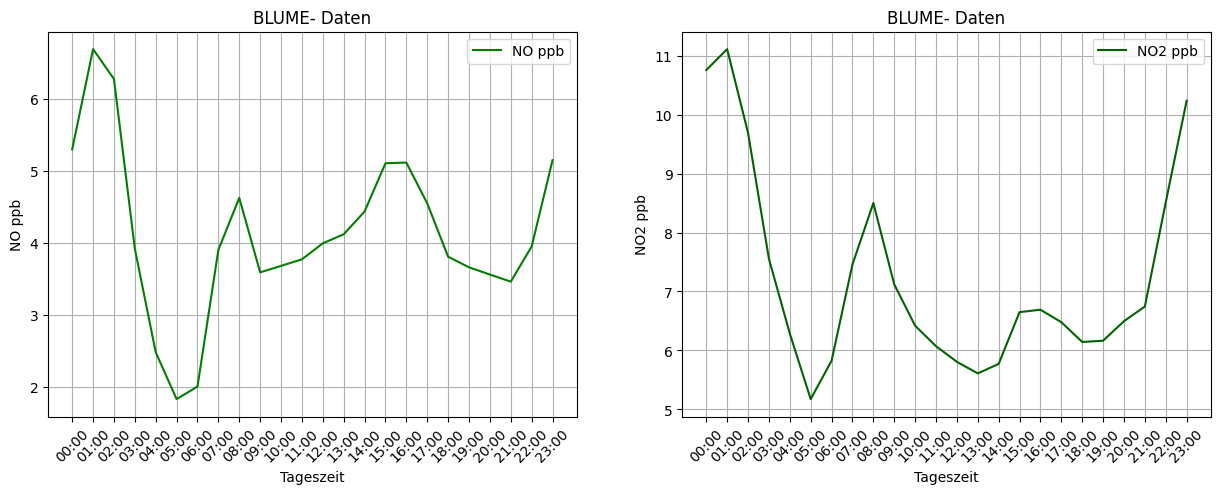

In [8]:
### Plots als Stundenmittel

fig_sidebyside_daytime, ax = plt.subplots(1,2,figsize=(15,5))

#NO
ax[0].plot(df_daytime['NO [ppb]'], color = 'green', label='NO ppb')
ax[0].set_xlabel('Tageszeit')
ax[0].set_ylabel('NO ppb')
ax[0].legend()
ax[0].xaxis.set_major_locator(HourLocator(byhour = 0))
ax[0].xaxis.set_major_formatter(DateFormatter(" %H:%M "))
ax[0].set_xticks(df_daytime.index,df_daytime.index,rotation=45)
ax[0].set_title('BLUME- Daten')
ax[0].xaxis.grid(True)
ax[0].yaxis.grid(True)

#NO2
ax[1].plot(df_daytime['NO2 [ppb]'], color = 'darkgreen', label='NO2 ppb')
ax[1].set_xlabel('Tageszeit')
ax[1].set_ylabel('NO2 ppb')
ax[1].legend()
ax[1].xaxis.set_major_locator(HourLocator(byhour = 0))
ax[1].xaxis.set_major_formatter(DateFormatter(" %H:%M "))
ax[1].set_xticks(df_daytime.index,df_daytime.index,rotation=45)
ax[1].set_title('BLUME- Daten')
ax[1].xaxis.grid(True)
ax[1].yaxis.grid(True)

plt.show()

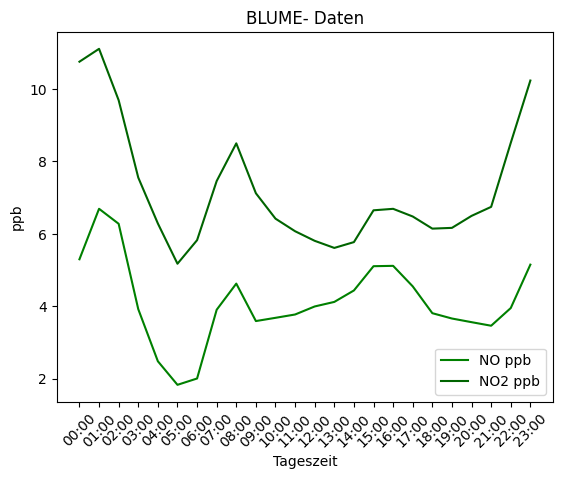

In [9]:
plt.plot(df_daytime['NO [ppb]'], color = 'green', label='NO ppb')
plt.plot(df_daytime['NO2 [ppb]'], color = 'darkgreen', label='NO2 ppb')
plt.xlabel('Tageszeit')
plt.ylabel('ppb')
plt.xticks(rotation=45)
plt.title('BLUME- Daten')
plt.legend()

## Numerische Untersuchung

In [10]:
### Durchschnittliche Konzentration über den Tag für NO und NO2:
df_daytime['NO [ppb]'].mean(),df_daytime['NO2 [ppb]'].mean()

(np.float64(4.123651225460928), np.float64(7.219347104501836))

In [11]:
### Bestimmtheitsmaße zwischen NO und NO2 für TU und BLUME

df = pd.read_csv('Dataframe from Abschlussprojekt for import to VisProject.csv', encoding =  "ISO-8859-1", sep=',')
df = df.set_index('Tageszeit')
df.rename(columns = {'NO ppb':'NO ppb TU','NO2 ppb':'NO2 ppb TU'},inplace = True)
df['NO ppb BLUME'] = df_daytime['NO [ppb]']
df['NO2 ppb BLUME'] = df_daytime['NO2 [ppb]']
M = df.corr()

In [12]:
print("Bestimmtheitsmaße R^2:")
print(f"NO TU/ NO BLUME:  {M['NO ppb TU']['NO ppb BLUME']**2}")
print(f"NO2 TU/ NO2 BLUME:  {M['NO2 ppb TU']['NO2 ppb BLUME']**2}")
print(f"NO TU/ NO2 TU:  {M['NO ppb TU']['NO2 ppb TU']**2}")
print(f"NO BLUME/ NO2 BLUME:  {M['NO ppb BLUME']['NO2 ppb BLUME']**2}")

Bestimmtheitsmaße R^2:
NO TU/ NO BLUME:  0.0006942376111317192
NO2 TU/ NO2 BLUME:  0.6158130906969419
NO TU/ NO2 TU:  0.0024201689105057054
NO BLUME/ NO2 BLUME:  0.5327808568940895


In [13]:
# Separate Untersuchung für die Zeiträume 8 bis 22 Uhr , 22 bis 8 Uhr 
begin = pd.to_datetime('08:00', format = '%H:%M')
end = pd.to_datetime('22:00', format = '%H:%M')
filt = ( (pd.to_datetime(df_daytime.index,format = '%H:%M') < end) & (pd.to_datetime(df_daytime.index,format = '%H:%M') >= begin) )
df_daytime_1 = df_daytime[filt]
df_daytime_2 = df_daytime[~filt]

In [14]:
df_daytime_1.corr()

,NO [ppb],NO2 [ppb]
NO [ppb],1.000000,0.217903
NO2 [ppb],0.217903,1.000000


In [15]:
df_daytime_2.corr()

,NO [ppb],NO2 [ppb]
NO [ppb],1.000000,0.950557
NO2 [ppb],0.950557,1.000000


In [16]:
0.217903**2, 0.950557**2

(0.04748171740900001, 0.903558610249)